## Introduction

Netflix is an American, subscription-based service offering online streaming from a library of films and television series, including those produced in-house. Similar to Netflix, Disney Plus service distributes films and television series produced by The Walt Disney Studios and Walt Disney Television and is one of the biggest competitor of Netflix. 

Due to Covid, there has been a tremendous increase in usage of OTT platform as cinemas were shut down and more people were staying home.

## Problem Statement

As more people are shifting towards OTT platform, we would like to get more insights in the similarities and differences between two of the most competitive online streaming platforms - Netflix and Disneyplus. This analysis would help understand users which platform is more suitable for them and hence which one they would like to choose.

**This notebook contains building and evaluation of models.**


### Contents

- [Import Combined Data](#Import-Combined-Data)
- [Train Test Split](#Train-Test-Split)
- [Modellinng](#Modelling)
    - [CountVectorizer & Logistic Regression](#Countvectorizer-and-Logistic-Regression)
    - [TfidfVectorizer & Logistic Regression](#TfidfVectorizer-and-Logistic-Regression)
    - [CountVectorizer & Naive Bayes](#CountVectorizer-and-Naive-Bayes)
    - [Countvectorizer & Random Forest Tree](#Countvectorizer-and-Random-Forest-Tree)
- [Model Comparison](#Model-Comparison)
- [Feature Importance](#Feature-Importance)
- [CountVectorizer & Random Forest With Additional Stopwords](#CountVectorizer-and-Random-Forest-With-Additional-Stopwords)
- [CountVectorizer & Naive Bayes With Additional Stopwords](#CountVectorizer-and-Naive-Bayes-With-Additional-Stopwords)
- [Test Predictions](#Test-Predictions)
- [Conclusion & Recommendations](#Conclusion-and-Recommendations)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from nltk.corpus import stopwords

## Import Combined Data

In previous notebook, we have cleaned and processed the data. Now here we will create few models and compare across them. <br>
First we will load the combined Netflix and Disney plus data.

In [2]:
netflix_disneyplus = pd.read_csv('../Data/Netflix_DisneyPlus_Cleaned.csv')

In [3]:
netflix_disneyplus.shape

(1276, 3)

In [4]:
netflix_disneyplus.head()

,selftext/title,cleaned_text,subreddit
0,Netflix now allows you to remove a movie/seri...,allow remov movi seri continu watch row,0
1,"Hello everyone, 8 years ago we woke up one day...",hello everyon year ago woke one day found one ...,0
2,STUDY: Majority of U.S. Parents Feel Guilty A...,studi major u parent feel guilti kid screen time,0
3,Looks like someone is trying to use Netflix a...,look like someon tri use platform send weird m...,0
4,Ozark season 4: Agent Maya Miller star shares...,ozark season agent maya miller star share firs...,0


In [5]:
netflix_disneyplus['subreddit'].value_counts()

1    669
0    607
Name: subreddit, dtype: int64

Above we can see that, the data is not too biased which is appropriate when we create our models.

## Train/Test Split

We have cleaned text which contains the cleaned and combined version of selftext and title data. This will be our feature on which we will build our models.<br>
We would like to classify the subreddits, so our target would be subreddit.

In [6]:
X = netflix_disneyplus['cleaned_text']
y = netflix_disneyplus['subreddit']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y, 
                                                    random_state=42)

In [8]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(957,) (957,) (319,) (319,)


In [9]:
y_train.value_counts(normalize=True)

1    0.524556
0    0.475444
Name: subreddit, dtype: float64

In [10]:
y_test.value_counts(normalize=True)

1    0.523511
0    0.476489
Name: subreddit, dtype: float64

As we have used stratify on our target while splitting data in train and test, the data is distributed fairly in both datasets.

## Modelling

We will try different models with our train and test data and compare the scores to understand and choose the best model. We will use Pipeline and Gridsearch to choose the best hyperparameters.


### Count Vectorizer & LogisticRegression

In [11]:
pipe_cv_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [12]:
params_cv_lr = {
    'cvec__max_features': [3000, 4000, 5000, 6000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [0.90, 0.95, 0.98],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'lr__C': [0.5, 0.8, 1]
}

In [13]:
gs_cv_lr = GridSearchCV(pipe_cv_lr,
                  param_grid=params_cv_lr,
                  cv=5)

In [14]:
gs_cv_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95, 0.98],
                         'cvec__max_features': [3000, 4000, 5000, 6000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'lr__C': [0.5, 0.8, 1]})

In [15]:
gs_cv_lr.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2),
 'lr__C': 0.5}

In [16]:
best_cvec_lr = gs_cv_lr.best_estimator_

In [17]:
cvlog_train_score = best_cvec_lr.score(X_train, y_train)
cvlog_train_score

0.9916405433646813

In [18]:
cvlog_test_score = best_cvec_lr.score(X_test, y_test)
cvlog_test_score

0.799373040752351

The accuracy for train data is about 99% which drops to 79% for test data. <br>
As we compare the scores for train and test data for the model using Countvectorizer and Logistic Regression, we can say that though the model has very good accuracy score for train data, it is way overfitting. 

### TfidfVectorizer & LogisticRegression

In [19]:
pipe_tf_lr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [20]:
params_tf_lr = {
    'tvec__max_features': [3000, 4000, 5000, 6000],
    'tvec__min_df': [1, 2, 3],
    'tvec__max_df': [0.90, 0.95, 0.98],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'lr__C': [0.4, 0.8, 1]
}

In [21]:
gs_tf_lr = GridSearchCV(pipe_tf_lr,
                     param_grid=params_tf_lr,
                     cv = 5)

In [22]:
gs_tf_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [0.4, 0.8, 1],
                         'tvec__max_df': [0.9, 0.95, 0.98],
                         'tvec__max_features': [3000, 4000, 5000, 6000],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [23]:
gs_tf_lr.best_params_

{'lr__C': 1,
 'tvec__max_df': 0.9,
 'tvec__max_features': 5000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [24]:
best_tvec_lr = gs_tf_lr.best_estimator_

In [25]:
tflog_train_score = best_tvec_lr.score(X_train, y_train)
tflog_train_score

0.9623824451410659

In [26]:
tflog_test_score = best_tvec_lr.score(X_test, y_test)
tflog_test_score

0.8056426332288401

The accuracy score for train and test data is about 96% and 80% respectively.<br>
If we compare the accuracy scores of the TfidfVectorizer and Logistic Regression model with the previous model, we can say that accuracy score dropped for train data but it increased for test data. Hence it is less overfitting from previous model.

### CountVectorizer & Naive Bayes

In [27]:
pipe_cv_nb = Pipeline([
    ('cvec' , CountVectorizer()),
    ('nb', MultinomialNB())
])

In [28]:
params_cv_nb = {
    'cvec__max_features': [3000, 4000, 5000, 6000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [0.90, 0.95, 0.98],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [0.8, 1, 1.2]
}

In [29]:
gs_cv_nb = GridSearchCV(pipe_cv_nb,
                        param_grid=params_cv_nb,
                        cv = 5)

In [30]:
gs_cv_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95, 0.98],
                         'cvec__max_features': [3000, 4000, 5000, 6000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'nb__alpha': [0.8, 1, 1.2]})

In [31]:
gs_cv_nb.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'nb__alpha': 0.8}

In [32]:
best_cv_nb = gs_cv_nb.best_estimator_

In [33]:
naive_train_score = best_cv_nb.score(X_train, y_train)
naive_train_score

0.9310344827586207

In [34]:
naive_test_score = best_cv_nb.score(X_test, y_test)
naive_test_score

0.799373040752351

The accuracy score for train and test data is abut 93% and 79% respectively.
Though the scores have dropped but Countvectorizer and Naive bayes model is less over fitting as compared to both the above models.

### Countvectorizer & Random Forest Tree

In [35]:
pipe_cv_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [36]:
params_cv_rf = {
    'cvec__max_features': [3000, 4000, 5000, 6000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [0.90, 0.95, 0.98],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 10, 15]
}

In [37]:
gs_cv_rf = GridSearchCV(pipe_cv_rf, param_grid=params_cv_rf, cv=5)

In [38]:
gs_cv_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'cvec__max_df': [0.9, 0.95, 0.98],
                         'cvec__max_features': [3000, 4000, 5000, 6000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'rf__max_depth': [5, 10, 15],
                         'rf__n_estimators': [50, 100, 200]})

In [39]:
gs_cv_rf.best_params_

{'cvec__max_df': 0.98,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 3),
 'rf__max_depth': 15,
 'rf__n_estimators': 100}

In [40]:
best_cv_rf = gs_cv_rf.best_estimator_

In [41]:
ranforest_train_score = best_cv_rf.score(X_train, y_train)
ranforest_train_score

0.8996865203761756

In [42]:
ranforest_test_score = best_cv_rf.score(X_test, y_test)
ranforest_test_score

0.7711598746081505

The accuracy score for train and test data for Countvectorizer and Random Forest model is about 85% and 77% respectively. <br>
Here too the score dropped but is way less overfitting in comparison to any of the models above.

### Model Comparison

In [43]:
scores = [['Train', cvlog_train_score, tflog_train_score, naive_train_score, ranforest_train_score],
          ['Test', cvlog_test_score, tflog_test_score, naive_test_score, ranforest_test_score]]
print (tabulate(scores, headers=["","CountVec+Logistic", "TfidVec+Logistic", "CountVec+Naive Bayes", "CountVec+Random Forest"]))

         CountVec+Logistic    TfidVec+Logistic    CountVec+Naive Bayes    CountVec+Random Forest
-----  -------------------  ------------------  ----------------------  ------------------------
Train             0.991641            0.962382                0.931034                  0.899687
Test              0.799373            0.805643                0.799373                  0.77116


Above table gives a better articulation of finer model from all. As mentioned previously we can say that CountVectorizer and Random Forest model gives good scores in terms of less overfitting. 

### Feature Importance

Using Random Forest model above we will try to understand the important features or words that played a significant role in classifying the subreddits.

In [50]:
def top30_features(best_pipe_model, title):
    feature_imp = best_pipe_model.named_steps.rf.feature_importances_
    sorted_idx = feature_imp.argsort().tolist()
    features = best_pipe_model.named_steps.cvec.get_feature_names()

    feature_imp_list = []
    features_list = []
    for i in range(len(sorted_idx)):
        feature_imp_list.append(feature_imp[sorted_idx[i]])
        features_list.append(features[sorted_idx[i]])
    
    features_imp_df = pd.DataFrame({'feature': features_list, 'feature_imp': feature_imp_list})

    features_top30 = features_imp_df.iloc[-30:, :]
    
    my_range=range(0,len(features_top30['feature']))

    plt.figure(figsize=(10,6))
    plt.stem(features_top30['feature_imp'])
    plt.xticks(my_range, features_top30['feature'], rotation='vertical')
    plt.title(title)

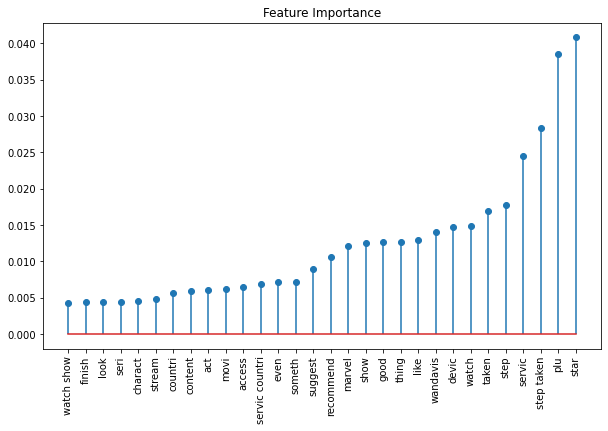

In [51]:
top30_features(best_cv_rf, 'Feature Importance')

From the top 30 features we can see that there are several general obvious words like service, watch, contri, recommend, character, device, like, access, etc that are common to both the streaming services. <br>
However there are few words like wandavis, stranger things, marvel, plu etc that might be unique to either of the subreddit.<br>
We can say that users on these subreddit are sharing their views, asking for recommendations for movies and series streaming on netflix or disney plus.<br>

Let us add some of these top features as stopwords and build another model to get to know more features/words/topics from these posts.

In [62]:
additional_stopwords = {'plu', 'star', 'servic', 'wandavis', 'taken', 'watch', 'stranger', 'things', 'like', 'marvel'}

### CountVectorizer & Random Forest With Additional Stopwords

In [63]:
pipe_cv_rf_new = Pipeline([
    ('cvec', CountVectorizer(stop_words=additional_stopwords)),
    ('rf', RandomForestClassifier())
])

In [64]:
params_cv_rf_new = {
    'cvec__max_features': [3000, 4000, 5000, 6000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [0.90, 0.95, 0.98],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [15, 20, 25]
}

In [65]:
gs_cv_rf_new = GridSearchCV(pipe_cv_rf_new, param_grid=params_cv_rf_new, cv=5)

In [66]:
gs_cv_rf_new.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words={'like',
                                                                    'marvel',
                                                                    'plu',
                                                                    'servic',
                                                                    'star',
                                                                    'stranger',
                                                                    'taken',
                                                                    'things',
                                                                    'wandavis',
                                                                    'watch'})),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'cvec__max_df': [0.9, 0.95, 0.98],
                    

In [67]:
gs_cv_rf_new.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'rf__max_depth': 20,
 'rf__n_estimators': 200}

In [68]:
best_cv_rf_new = gs_cv_rf_new.best_estimator_

In [69]:
ranfor_train_score_new = best_cv_rf_new.score(X_train, y_train)
ranfor_train_score_new

0.890282131661442

In [70]:
ranfor_test_score_new = best_cv_rf_new.score(X_test, y_test)
ranfor_test_score_new

0.7241379310344828

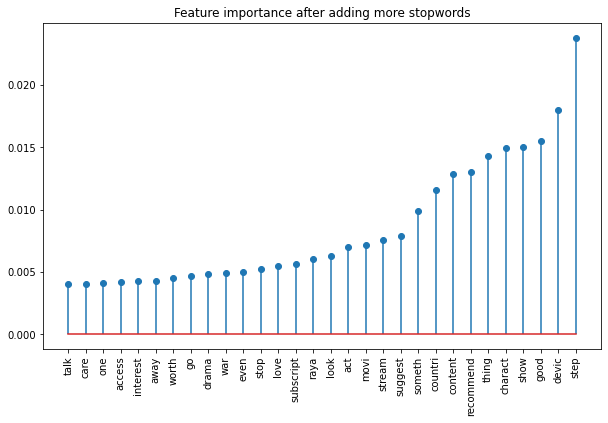

In [72]:
top30_features(best_cv_rf_new, 'Feature importance after adding more stopwords')

After removing the stopwords, we can get more insights about the genre like drama, war, love and movie like raya in addition to other new features like subscript, interest, care, etc. 

Let us create a new model with Naive Bayes which will include the stopwords declared above so that we can get better understanding of which model is better after introducing the stopwords.

### CountVectorizer & Naive Bayes With Additional Stopwords

In [73]:
pipe_cv_nb_new = Pipeline([
    ('cvec' , CountVectorizer(stop_words = additional_stopwords)),
    ('nb', MultinomialNB())
])

In [74]:
params_cv_nb_new = {
    'cvec__max_features': [3000, 4000, 5000, 6000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [0.90, 0.95, 0.98],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [0.8, 1, 1.2]
}

In [75]:
gs_cv_nb_new = GridSearchCV(pipe_cv_nb_new,
                        param_grid=params_cv_nb_new,
                        cv = 5)

In [76]:
gs_cv_nb_new.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words={'like',
                                                                    'marvel',
                                                                    'plu',
                                                                    'servic',
                                                                    'star',
                                                                    'stranger',
                                                                    'taken',
                                                                    'things',
                                                                    'wandavis',
                                                                    'watch'})),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95, 0.98],
                         'cve

In [77]:
gs_cv_nb_new.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 6000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2),
 'nb__alpha': 0.8}

In [82]:
best_cv_nb_new = gs_cv_nb_new.best_estimator_

In [83]:
naive_train_score_new = best_cv_nb_new.score(X_train, y_train)
naive_train_score_new

0.9425287356321839

In [84]:
naive_test_score_new = best_cv_nb_new.score(X_test, y_test)
naive_test_score_new

0.7711598746081505

**Model Comparison (After adding stopwords)**

In [85]:
scores = [['Train', naive_train_score_new, ranfor_train_score_new],
          ['Test', naive_test_score_new, ranfor_test_score_new]]
print (tabulate(scores, headers=["", "CountVec+Naive Bayes", "CountVec+Random Forest"]))

         CountVec+Naive Bayes    CountVec+Random Forest
-----  ----------------------  ------------------------
Train                0.942529                  0.890282
Test                 0.77116                   0.724138


After we introduced additional stopwords the accuracy score dropped which is expected as more words were missing for classifying the subreddits. Now if we compare the Naive Bayes and Random Forest we can see that the Naive Bayes is performing better in terms of accuracy score. Moreover both the models are doing well of not overfitting on huge scale. Hence we would use Naive Bayes to predict our test data.

### Test Predictions

In [122]:
predictions = best_cv_nb_new.predict(X_test)

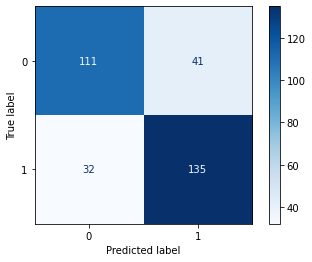

In [88]:
plot_confusion_matrix(best_cv_nb_new, X_test, y_test, cmap='Blues');

For posts classification, 0 indicates Netflix and 1 indicates Disney Plus. <br>
Here confusion matrix gives an overview of the predicted test data. There are 32 False Negetive(Actually Disney Plus but predicted Netflix) and 41 False Positive (Actually Netflix but predicted Disney Plus). In total there are 73 misinterpretd posts.

In [89]:
tn, fp, fn , tp = confusion_matrix(y_test, predictions).ravel()

In [93]:
accuracy = (tp + tn) / (tn + fp + fn + tp)

In [95]:
print('Accuracy score :', accuracy)

Accuracy score : 0.7711598746081505


In [91]:
predictions_df = pd.DataFrame({'clean_text': X_test,'predicted': predictions, 'actual': y_test})

In [98]:
misinterpreted = predictions_df[predictions_df['predicted'] != predictions_df['actual']]
misinterpreted

,clean_text,predicted,actual
510,watch littl enjoy last day keep reset time epi...,1,0
385,know use app get disc mailbox rent origin prog...,1,0
191,hello use philippin reason find two anim catal...,1,0
459,anyon know maximum amount credit appli account...,1,0
681,plu grey compar blu ray,0,1
...,...,...,...
508,best anim show watch,1,0
62,anyon get compress artifact like bright white ...,1,0
907,hi chanc hide seri film individu episod seen w...,0,1
102,receiv new download featur app decid movi tv s...,1,0


In [107]:
pd.set_option('display.max_colwidth', None)
misinterpreted_netflix = predictions_df[(predictions_df['actual'] != predictions_df['predicted']) & 
                                        (predictions_df['actual'] == 0)]
misinterpreted_netflix

,clean_text,predicted,actual
510,watch littl enjoy last day keep reset time episod time close app phone roku tri stop found way isnt huge deal realli annoy anyon know fix could tell would realli appreci need help,1,0
385,know use app get disc mailbox rent origin program big studio indi releas via dvd bluray anyon subscrib via physic mail,1,0
191,hello use philippin reason find two anim catalog dorohedoro beastar correct wrong anim exclus region go seen seri movi disappear due expir licens own show see realli want resort use virtual privat network help find show appreci thank answer advanc origin anim show,1,0
459,anyon know maximum amount credit appli account bought chromecast googl tv month credit allow redeem last one reason maximum credit,1,0
240,year pandem end sight given free trial gt lt know start what best show first time user readi go rabbit hole first time user,1,0
166,anyon know get app roku run like crap crash randomli constantli amaz compani resourc seem make app crash run sluggishli unsubscrib year ago support utterli clueless told workaround unplug roku tv minut everi time app act well would fine actual fix start head back unsubscrib direct anyon clever way get garbag app actual function edit scroll kneelray advic turn auto play featur option avail websit appear complet fix lag crash log websit go account gt profil gt playback set gt chang turn auto play featur note make chang log primari account chang everi profil one thank kneelray fix everyth roku app constantli crash,1,0
134,around last week watch da vinci code search sequel angel amp demon find search dav vinci code find eiter find movi watch last week,1,0
397,sure go titl look like someon asleep wheel ingest sent studio letterbox imag massiv offset toward bottom screen constant drop frame titl burn eg h obviou pretti sure badli convert p p test two player appletv k latest beta play p p properli nvidia shield legaci lie uk ofcentr letterbox bake p gt drop frame artifact,1,0
269,spend million korean content year,1,0
417,bought gb microsd card usual consum content go offlin time download content sourc annoy download titl want use smart download delet like rewatch show time time given long good seri difficult watch offlin cannot download everyth anyon els annoy download limit,1,0


In [120]:
misinterpreted_disneyplus = predictions_df[(predictions_df['actual'] != predictions_df['predicted']) & 
                                        (predictions_df['actual'] == 1)]
misinterpreted_disneyplus

,clean_text,predicted,actual
681,plu grey compar blu ray,0,1
1062,pretti excit we anderson watch parti first show watch star,0,1
1212,hi start watch age ultron first time feel like first scene saw vision ultron say vision explan mean know movi explain youtub scene thor vision vision hold hammer rmmbr see movi neither vision birth feel like trip bad anyon time care enough put time stamp liter see mine age ultron miss scene,0,1
936,land choir docuseri detroit youth choir,0,1
749,research imagin stori crave depth reveal park hope someth work haha plan releas show ride park thought rememb suppos someth like,0,1
1044,rip episod,0,1
1082,hope feel nostalg today,0,1
948,still keep joke hulu know one episod wonder cut non us audienc random question solar opposit,0,1
1015,pleas make titl part quit button lost count amount time accident quit movi tap screen high,0,1
1130,fascin foley sound design long time featur someth want ever sinc special featur monster inc dvd came refresh watch scene without music implement movi yet addit audio track mani movi would repurchas remov music hear natur audio zenim featur amaz,0,1


While analysing feature importance, we recognized that there are several common words between Netflix and Disney Plus which play an important part in predicting the individual subreddits. Such common words like watch, episode, season etc and some unique words like plu, wandavis, stranger things, etc were added in stopwords list. <br>

In addition to this, most of the posts would either talk about a specific show or some inquiry related to the platform. If the show/series was mentioned only once(which would be quite normal considering new shows come up every month) there is a possibility that those features would not affect the prediction as they are the least occurring words. And if the post is about some inquiry related to a platform, it becomes very generalized as words like subscription, access, device, etc are very common in both the subreddit posts. Hence in these scenarios it would be difficult to interpret the posts.

## Conclusion & Recommendation

**Conclusion:**

We compared several models through their accuracy scores with and without additional stopwords added. The score was much better without the additional stopwords, but the later would give us more ethical predictions and would not be too biased. So the final model chosen was Naive Bayes with CountVectorizer which returned an accuracy score of 77% for test data.

Now from the analysis we can say that there are several obvious common words between netflix and disney plus like watch, series, tv, season, like, recommend, movi, stream, finish and so on. From these words we can interpret that people in general are talking about watching/recommending or have finish watching a series or a movie on a streaming platform. 

In addition to these, other common words like access, subscript, contri, etc would depict that they are also talking or inquiring about the subscription or access policies in different countries.

We can also derive from the analysis that people on the subreddit posts are talking about varied genres like crime, marvel, drama, war, love, documentri, anime.

Aside from the common words unique words like wandavision, stranger things, raya, drama, war, marvel etc which are sepcific to one platform also came up in the top 30 features that were important in predicting the posts. Here we can get a clear understanding of which words belong to which platform. <br>
Examples: 
- Wandavision is the new series aired in January 2021 on disney plus. 
- Stranger things is the American series on Netflix since 2016.
- Now if we consider drama and marvel features, we can clearly say that disney plus airs most of the marvel movies and netflix airs most of the drama movies/series.


From the exploratory analysis and feature importance, we can say that fewer movies or series name were highlighted. The reason behind this might be that the new series/movies are aired all the time on both the platforms, and so it seldom occurs that the same movie or series is mentioned several times to come up in the top discussed words which is expected. However, w egot better insights of movie names from disney plus posts as compared to netflix posts. Maybe can dig out more features by adding more stop words in future analysis.

**Recommendations:**

- Disney plus contains movies like wandavision which is a superhero fiction movie. It also contains few anime movies like raya the last dragon, the simpsons, etc. Hence based on the above and external analysis, on genres basis we can suggest users to go for Disney plus if they are more interested in marvel, animated movies or series.
- Fewer named of movies and series came up in our analysis but features like drama, stranger things (series on netflix), documentary, anime etc suggest that if users are more inclined towards these genres should go for netflix.